<a href="https://colab.research.google.com/github/IsuruKasun/4_Year_Project_Web_Interface_html_javascript/blob/main/SYSC4415W23_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYSC4415 - Assignment 2

**TA: François Charih \<francois@charih.ca\>**

**Deadline: March 19th, 2023 @ 11:59PM**

## Learning objectives

1. Fine-tune pre-trained CNN architectures for a custom image classification challenge.

2. Evaluate the performance of machine learning models using different metrics (precision-recall curve, confusion matrices, *etc.*).

3. Get hands-on experience with modern machine learning and plotting libraries.

## Instructions

1. Give yourself plenty of time to complete the assignment (it could take you up to 8-10 hours if you are unfamiliar with Python and machine learning libraries). The models should not take more than 1h to fine-tune (my full notebook runs from start to end in a little under 40 minutes. Coding will be the most time-consuming. ⚠️**Do not wait to the last minute.** ⚠️

2. You must use the prescribed methods/functions/libraries mentioned, whenever specified. The functions you need are already imported for you in the appropriate sections. You can reorganize the imports and import the full packages instead of specific functions if you so desire. I imported the necessary functions for you so that they are ready to be invoked without have to specify the full path to the functions with the dot operator (i.e. so that you invoke `function()` instead of `package.module.function()`).

3. Make sure to include comments for non-trivial code. It is okay to add some code cells, if you think it will give your code better readability/structure.

4. If you are unsure about something, clearly state your assumptions and complete the question based off these assumptions.

5. Be careful as you complete the assignment. There are several text-based questions to be answered in Markdown (text) cells. The questions are accompanied by the ❓ emoji. Your answers should be entered in the markdown cells with the 📝 emoji.

6. Submit your Notebook as a `.ipynb` file that adopts this naming convention: *SYSC4415W23_A2_\<First Name\>_\<Last Name\>_\<StudentID\>.ipynb* on Brightspace. I should be able to run your code without errors.

7. Make sure you enable a GPU accelerator (in Runtime > Change runtime type) starting at Part 4 and that your training code uses it. GPU resources are limited, so it is recommended not to use the accelerator for prior steps.

8. All plots should be made with matplotlib and labeled properly (ie. include axis labels and legends).

## Context

It is 2030, and a new RNA virus named SARS-CoV-3 is wreaking havoc across the globe. Its death rate is estimated at 95%, making it one of the deadliest  respiratory viruses known to mankind. Fortunately, an Ottawa-based biotech company developed a nasally-delivered vaccine *Greenraza*™️ that can neutralize the virus in living patients. However, administrating the vaccine increases the risk of lung cancer by a whooping 60%. It is therefore vital that the drug be administered to infected patients only, not to patients infected with another respiratory virus such as the common cold or influenza. The virus cannot be detected through blood or breath analyses. It can only be detected by means of x-ray imaging.

Having heard of your newly developed expertise in deep learning, you have been tasked by the Ottawa Hospital with the design of a machine learning model capable of distinguishing patients infected with SARS-CoV-3 from patients that have pneumonia and non-infected patients. Healthy patients can be discharged, while patients with pneumonia must be isolated, but without being given *Greenraza*™️.

## Project initialization

Run the cells below to set-up the notebook (ie. download the dataset) and install the required external libraries.

In [ ]:
# RUN THIS (downloads the dataset)
! rm -rf SYSC4415W23_A2_dataset SYSC4415W23_A2_dataset.zip
! wget https://github.com/jrgreen7/SYSC4906/releases/download/Assignment2/SYSC4415W23_A2_dataset.zip && unzip SYSC4415W23_A2_dataset.zip

In [ ]:
# RUN THIS (installs external libraries)
!pip install timm
!pip install git+https://github.com/nottombrown/imagenet_stubs
!pip install torchstat

## Part 1: Preparing the dataset

The Ottawa Hospital has provided you with a dataset to develop your model. The dataset is available here. The dataset contains a folder containing a spreadsheet with metadata for each image in the dataset and a subfolder containing the 200x200 images (with random filenames).

In [ ]:
from pandas import read_csv
from matplotlib.pyplot import bar, xlabel, ylabel, title

**Step 1:** Using pandas' `read_csv` function, load the dataframe containing the image metadata (`dataset_metadata.csv`).

In [ ]:
# Loads the image metadata into a pandas dataframe

# YOUR CODE HERE
df = read_csv('/content/SYSC4415W23_A2_dataset/dataset_metadata.csv')

**Step 2:** Use the `head` method to print the top five rows of the dataframe.

In [ ]:
# Prints the top five rows in the dataset

# YOUR CODE HERE
df.head()

,filename,split,xray_date,height,width,label
0,272_normal.jpg,training,2030-11-18 06:50:42,200,200,normal
1,788_normal.jpg,training,2030-06-20 21:32:45,200,200,normal
2,622_normal.jpg,training,2030-07-12 06:56:19,200,200,normal
3,1138_normal.jpg,training,2030-03-15 13:52:16,200,200,normal
4,1568_normal.jpg,training,2030-12-22 22:09:18,200,200,normal


**Step 3:** Using pandas' [query method](https://pandas.pydata.org/docs/user_guide/indexing.html#the-query-method) and the `len` methods on the selections, print the number of images in the training, validation and test sets.

In [ ]:
# Prints the dimensions of the dataframe

# YOUR CODE HERE
print("Number of images in training set: " + str(len(df.query('split == "training"'))))
print("Number of images in validation set: " + str(len(df.query('split == "validation"'))))
print("Number of images in test set: " + str(len(df.query('split == "test"'))))

Number of images in training set: 2222
Number of images in validation set: 645
Number of images in test set: 505


**Step 4:** Using the `value_counts` method on the “label” column, provide the composition of the dataset in terms of the number of SARS-CoV-3 cases, pneumonia cases and healthy x-rays. In another cell, prepare a bar chart from that data using matplotlib's `bar` method. Note that the result of the `value_counts` methods is a series object whose property `index` is the label.

In [ ]:
# Generates a breakdown of the images' classes

# YOUR CODE HERE
vc = df.value_counts('label')
print(vc)

label
normal       1500
pneumonia    1300
sarscov3      572
dtype: int64


<Axes: xlabel='label'>

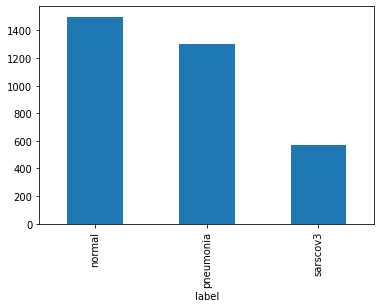

In [ ]:
# Plots a bar chart

# YOUR CODE HERE
vc.plot.bar()

❓ ***Question: Is the data balanced or not? If not, specify why class imbalance makes classification more difficult, and suggest one method you could use to deal with the imbalanced data.***

📝 YOUR ANSWER GOES HERE

The data is imbalanced as there is not an equal number of examples for each class. This can result in bias and poor perfomance in classifying classes with fewer examples. In this problem, classifying sarscov3 would be harder. 

## Part 2: Applying pre-trained CNN models to the data

Researchers make pre-trained neural networks available to the community at large. There are many, many pre-trained CNNs available in online repositories that researchers can leverage for their own applications.

In [ ]:
from torchvision.io import read_image
from timm import create_model
from matplotlib.pyplot import imread, imshow
from imagenet_stubs.imagenet_2012_labels import label_to_name

**Step 1:** Display the image `SYSC4415W23_A2_dataset/training/sarscov3/100_sarscov3.jpg` from the test set. The matplotlib methods `imread` and `imshow` are useful. 😉

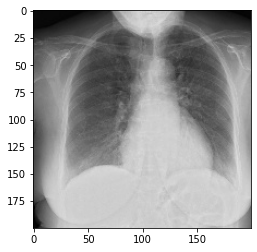

In [ ]:
# Display the image with matplotlib's imread/imshow

# YOUR CODE HERE
imshow(imread('/content/SYSC4415W23_A2_dataset/training/sarscov3/100_sarscov3.jpg'))

**Step 2:** Load the ImageNet-pretrained InceptionV3 (`inception_v3`) and ResNet50 (`resnet50`) models with `timm` (this was done in Anthony's CIFAR100 tutorial with PyTorch). Use them to predict the class of the image along with the probability (not the logit). The probability is the result of applying the softmax function to the logits.

Of course, because the models were pretrained on ImageNet, it will not predict any of the classes that interest us.

***Notes:**
1. The `read_image` function can convert an image on disk to a tensor.

2. The function `label_to_name` that I imported for you converts the index of an ImageNet class to its English name.

In [ ]:
from matplotlib import image
# Loads the image in a Tensor (the method read_image can load the image in a tensor), calls unsqueeze(0) on the tensor to add a dimension and convert its entries to floats using the .float() method

# YOUR CODE HERE
image_tens = read_image('/content/SYSC4415W23_A2_dataset/training/sarscov3/100_sarscov3.jpg').unsqueeze(0).float()
print(image_tens.size())

torch.Size([1, 3, 200, 200])


In [ ]:
# Loads the InceptionV3 model predicted class along with its probability
import torch # ADDED
# YOUR CODE HERE
imodel = create_model('inception_v3', pretrained=True)

with torch.no_grad():
    out = imodel(image_tens)

probabilities = torch.nn.functional.softmax(out[0], dim=0)

top_prob, top_catid = torch.topk(probabilities, 1)

print('Predicted class: ' + label_to_name(top_catid[0].item()))
print('Probability: ' + str(top_prob[0].item()))

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


Predicted class: lighter, light, igniter, ignitor
Probability: 0.001745817018672824


In [ ]:
# Loads the ResNet50 model predicted class along with its probability

# YOUR CODE HERE
rmodel = create_model('resnet50', pretrained=True)

with torch.no_grad():
    out = rmodel(image_tens)

probabilities = torch.nn.functional.softmax(out[0], dim=0)

top_prob, top_catid = torch.topk(probabilities, 1)

print('Predicted class: ' + label_to_name(top_catid[0].item()))
print('Probability: ' + str(top_prob[0].item()))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


Predicted class: nail
Probability: 0.004312699194997549


❓ ***Question: What classes are predicted for the two models? Are the models confident? Is it a good thing?***

📝 YOUR ANSWERS GO HERE

For the InceptionV3 model, it predicts the class: 'lighter, light, igniter, ignitor' with a probability of 0.00174 or 0.174%. 

The ResNet50 model predicts the class 'nail' with a probability of 0.00431 or 0.431%.

Both models are not confident in their prediction given by their probability which is a good thing since the image is neither of the two classes and has no correlation to being either of them.

## Part 3: Instantiating the dataloaders to perform fine tuning
When working with large image datasets with PyTorch, people often implement a DataLoader to help manage how images are loaded during training. The dataloader can be combined with methods that implement data augmentation by modifying the images with transforms (eg. scaling, rotation, reflection, cropping, etc.). For the most common applications, there are existing data loaders that are perfectly suitable and that users can use instead of defining their own.


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

**Step 1:** Using the `ImageFolder` strategy to build a dataloader with a batch size of 128 for training. ([This tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#afterword-torchvision) is most helpful.)

You will also want your dataloader for your training set to apply the following data augmentation transforms (documentation available [here](https://pytorch.org/vision/stable/transforms.html)):

1. Random rotation between -10 and 10 deg
2. Random horizontal flip with 40% probability

In [ ]:
# Creates the dataset and dataloader that will be used for training

# YOUR CODE HERE

batch_size = 128

data_transform = transforms.Compose([transforms.RandomRotation(10), transforms.RandomHorizontalFlip(0.4), transforms.ToTensor()])

train_ds = ImageFolder(root='/content/SYSC4415W23_A2_dataset/training', transform=data_transform)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

**Step 2**: Create the dataloaders you will be using for validation and testing. The transform should only convert the images to a tensor. You should not specify a batch size for the test set dataloader.

In [ ]:
# Creates the dataloader that will be used for validation

# YOUR CODE HERE
val_ds = ImageFolder(root='/content/SYSC4415W23_A2_dataset/validation', transform=transforms.ToTensor())

val_dl = DataLoader(val_ds, batch_size=batch_size)

In [ ]:
# Creates the dataloader that will be used testing

# YOUR CODE HERE
test_ds = ImageFolder(root='/content/SYSC4415W23_A2_dataset/test', transform=transforms.ToTensor())

test_dl = DataLoader(test_ds)

## Part 4: Fine-tuning existing CNN architectures

The Inception V3 and ResNet50 models you loaded above were trained on ImageNet which is not a medical dataset. In order to leverage these models for our purposes, we need to modify the architecture so that the final classification layer contains an appropriate number of classes and retune the model weights so that the models become suitable for the classification of our x-rays.


In [ ]:
from timm import create_model
import time
from matplotlib.pyplot import subplots
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch import no_grad, Tensor

**Step 1:** Using `create_model` from the `timm` package, Load the InceptionV3 and ResNet50 models, replacing the final layer with one appropriate for our purpose (recall that we want to classify x-rays of healthy, pneumonia and SARS-CoV-3 patients). Note that the timm library can assist in replacing the final layer (see [Anthony's tutorial](https://github.com/jrgreen7/SYSC4906/blob/master/W2023/Tutorials/CIFAR100_tutorial_WIP.ipynb)). These are your modified models.

In [ ]:
# Loads the InceptionV3 model and replaces the final classification layer with a new dense layer

# YOUR CODE HERE
imodel = create_model('inception_v3', num_classes = 3, pretrained=True)

In [ ]:
# Loads the ResNet50 model and replaces the final classification layer with a new dense layer

# YOUR CODE HERE
rmodel = create_model('resnet50', num_classes = 3, pretrained=True)

**Step 2:** In a tutorial with Anthony, you have seen that you can convert a base learning rate to an effective learning rate based on the batch size you have selected using the following heuristic:

$$\eta_{eff} = \frac{B\eta_{base}}{256}$$

where $\eta$ is the learning rate and $B$ is the batch size.

Train the final layer modified InceptionV3 and ResNet50 models on your training set. Use the **base** learning rate $\eta_{base}$ of 0.0005.

Use the following settings:

**Epochs:** 25

**Optimizer:** AdamW

**Loss function:** Cross-entropy (it is not required here, but note that using the weight parameter here could help deal with class imbalance)

Implement the training loop yourself. Do not use a package that automates the process. Anthony has demonstrated how to do this and much can be taken from [his example](https://github.com/jrgreen7/SYSC4906/blob/master/W2023/Tutorials/CIFAR100_tutorial_WIP.ipynb).

❗**Important: Make sure you are using a colab gpu and to store the mean training and validation performance/loss at each epoch as you will be plotting them in the next steps.**

In [ ]:
# Moves the modified inceptionV3 model to GPU

# YOUR CODE HERE
imodel.cuda()

In [ ]:
# Instantiates the optimizer for the modified InceptionV3 model using the specified effective learning rate

# YOUR CODE HERE
base_rate = 5e-4
learning_rate = base_rate * batch_size / 256
epochs = 25

opt = AdamW(imodel.parameters(), lr=learning_rate)

In [ ]:
# Sets up the loss function for the modified InceptionV3 model

# YOUR CODE HERE
loss_function = CrossEntropyLoss()

In [ ]:
# Fine-tunes the weights in the final layer the modified InceptionV3 model (main learning loop)

# YOUR CODE HERE

imodel_tl = []
imodel_vl = []

for epoch in range(epochs):
    start_time = time.time()
    train_losses = []
    imodel.train()
    for batch in train_dl:
        batch_imgs, batch_labels = batch
        batch_imgs = batch_imgs.cuda()
        batch_labels = batch_labels.cuda()

        logits = imodel(batch_imgs)
        loss = loss_function(logits, batch_labels)
        loss.backward()

        opt.step()
        opt.zero_grad()
        train_losses.append(loss.item())

    val_losses = []
    imodel.eval()
    with torch.no_grad():
        for batch in val_dl:
            batch_imgs, batch_labels = batch
            batch_imgs = batch_imgs.cuda()
            batch_labels = batch_labels.cuda()

            logits = imodel(batch_imgs) 
            loss = loss_function(logits, batch_labels)
            val_losses.append(loss.item())

    train_time = time.time() - start_time
    epoch_train_loss = torch.Tensor(train_losses).mean().item()
    imodel_tl.append(epoch_train_loss)
    epoch_val_loss = torch.Tensor(val_losses).mean().item()
    imodel_vl.append(epoch_val_loss)
    print(f'Epoch: {epoch}  Train Loss: {epoch_train_loss:8.6f}   Val Loss: {epoch_val_loss:8.6f}  Time: {train_time:6.4f}')


In [ ]:
# Moves the modified ResNet50 model to GPU

# YOUR CODE HERE
rmodel.cuda()

In [ ]:
# Instantiates the optimizer for the modified ResNet50 model

# YOUR CODE HERE
base_rate = 5e-4
learning_rate = base_rate * batch_size / 256
epochs = 25

opt2 = AdamW(rmodel.parameters(), lr=learning_rate)

In [ ]:
# Sets up the loss function for the modified ResNet50 model

# YOUR CODE HERE
loss_function2 = CrossEntropyLoss()

In [ ]:
# Fine-tunes the weights in the final layer the modified ResNet50 model (main learning loop)

# YOUR CODE HERE
rmodel_tl = []
rmodel_vl = []

for epoch in range(epochs):
    start_time = time.time()
    train_losses = []
    rmodel.train()
    for batch in train_dl:
        batch_imgs, batch_labels = batch
        batch_imgs = batch_imgs.cuda()
        batch_labels = batch_labels.cuda()

        logits = rmodel(batch_imgs)
        loss = loss_function2(logits, batch_labels)
        loss.backward()

        opt2.step()
        opt2.zero_grad()
        train_losses.append(loss.item())

    val_losses = []
    rmodel.eval()
    with torch.no_grad():
        for batch in val_dl:
            batch_imgs, batch_labels = batch
            batch_imgs = batch_imgs.cuda()
            batch_labels = batch_labels.cuda()

            logits = rmodel(batch_imgs) 
            loss = loss_function2(logits, batch_labels)
            val_losses.append(loss.item())

    train_time = time.time() - start_time
    epoch_train_loss = torch.Tensor(train_losses).mean().item()
    rmodel_tl.append(epoch_train_loss)
    epoch_val_loss = torch.Tensor(val_losses).mean().item()
    rmodel_vl.append(epoch_val_loss)
    print(f'Epoch: {epoch}  Train Loss: {epoch_train_loss:8.6f}   Val Loss: {epoch_val_loss:8.6f}  Time: {train_time:6.4f}')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(imodel.state_dict(), '/content/drive/MyDrive/imodel')
torch.save(rmodel.state_dict(), '/content/drive/MyDrive/rmodel')

Mounted at /content/drive


**Step 3:** In different labeled subplots, display the learning curves for each model. Each subplot should display loss on the training set and the validation set (*i.e.* 2 curves per subplot). Use matplotlib.

Text(0.5, 1.0, 'ResNet50 Loss Curve')

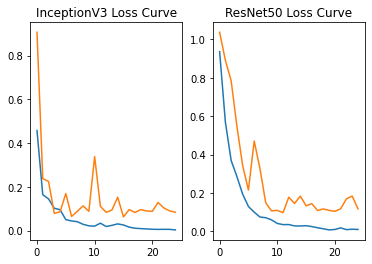

In [ ]:
# Displays the learning curves (loss) for both models in two separate subplots

# YOUR CODE HERE
x_axis = list(range(0, 25))
fig, (ax1, ax2) = subplots(1, 2)
ax1.plot(x_axis, imodel_tl, x_axis, imodel_vl)
ax1.set_title('InceptionV3 Loss Curve')
ax2.plot(x_axis, rmodel_tl, x_axis, rmodel_vl)
ax2.set_title('ResNet50 Loss Curve')

❓ ***Question: Comment on your learning curves. What do they tell you?***

📝 YOUR ANSWER GOES HERE

The learning curves indicate that the model is able to optimize itself quite well as the loss in the training curve decreases exponentially approaching 0. The validation curves also indicate the model is able to generalize although some indicate of overfitting is present as the validation curves can be seen to spike at certain epochs. Overall, the validation curves approach 0 which indicates a good model. 

The curves also indicate the InceptionV3 optimizing faster than ResNet50.

## Part 5: Performance evaluation on a test set

Of course, estimating the performance of your model on unseen data is a key step in machine learning methodology. Here, you will summarize model performance for your InceptionV3 model and ResNet50 model on the test set.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
from torch import no_grad

**Step 1:** Iterate through the images in the test set using the test dataloader to make predictions for the test set images and retrieve their actual label (its index). Note that this is done in a way similar to the validation step in the training loop.

Append the predicted class index to a list, the actual labels to another and the probability of the SARS-CoV-3 class to another list.

Do this for both fine-tuned models.

Note that the indices map to the classes as follows:

0: normal

1: pneumonia

2: sarscov3

In [ ]:
# Creates a list of predictions, a list of actual labels and a list of probabilities of the SARS-CoV-3 class for the fine-tuned InceptionV3 model applied to the test set

# YOUR CODE HERE

predicted = []
actual = []
probability = []

with torch.no_grad():
    for img in test_dl:
        img_img, img_label = img
        actual.append(img_label.item())
        img_img = img_img.cuda()
        img_label = img_label.cuda()

        logits = imodel(img_img)
        probabilities = torch.nn.functional.softmax(logits[0], dim=0)

        top_prob, top_catid = torch.topk(probabilities, 1)
        predicted.append(top_catid.item())
        probability.append(top_prob.item())

In [ ]:
print(actual)
print(predicted)
print(probability)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
# Creates a list of predictions, a list of actual labels and a list of probabilities of the SARS-CoV-3 class for the fine-tuned ResNet50 model applied to the test set

# YOUR CODE HERE
predicted2 = []
actual2 = []
probability2 = []

with torch.no_grad():
    for img in test_dl:
        img_img, img_label = img
        actual2.append(img_label.item())
        img_img = img_img.cuda()
        img_label = img_label.cuda()

        logits = rmodel(img_img)
        probabilities = torch.nn.functional.softmax(logits[0], dim=0)

        top_prob, top_catid = torch.topk(probabilities, 1)
        predicted2.append(top_catid.item())
        probability2.append(top_prob.item())

In [ ]:
print(actual2)
print(predicted2)
print(probability2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

**Step 2:** Show the confusion matrices for both models. The `confusion_matrix` function from scikit-learn I imported for you is useful for this.

In [ ]:
# Creates the confusion matrix for the modified InceptionV3 model
 
# YOUR CODE HERE
confusion_matrix(actual, predicted)

array([[227,   6,   0],
       [  7, 193,   0],
       [  0,   1,  71]])

In [ ]:
# Creates the confusion matrix for the modified ResNet50 model

# YOUR CODE HERE
confusion_matrix(actual2, predicted2)

array([[215,  18,   0],
       [  1, 199,   0],
       [  0,   0,  72]])

❓ ***Question: Based off these matrices, report the accuracy of the models.***

📝 YOUR ANSWER GOES HERE

For InceptionV3:

Accuracy = (TP_n + TP_p + TP_s) + FN) / Total = (227+193+71) / 505 = 0.972 = 97.2 %

For ResNet50:

Accuracy = (TP_n + TP_p + TP_s) / Total = (215+199+72) / 505 = 0.962 = 96.2 %

**Step 3:** Use the `PrecisionRecallDisplay.from_predictions` methods documented [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=The%20precision%2Drecall%20curve%20shows,a%20low%20false%20negative%20rate.) to plot the precision recall curves for your models. There are three classes, so convert your labels so that it becomes a binary classification scenario, ie. SARS-CoV-3 vs. not-SARS-CoV-3.

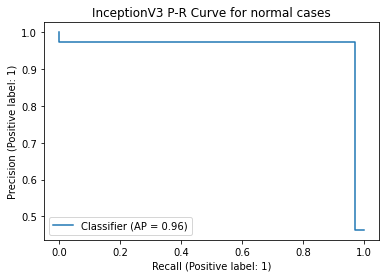

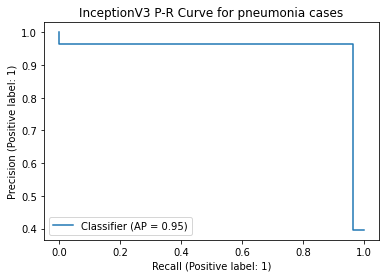

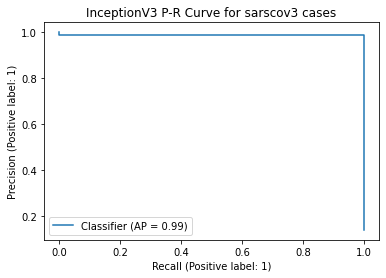

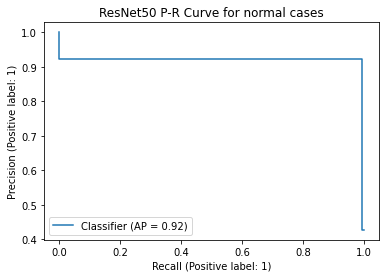

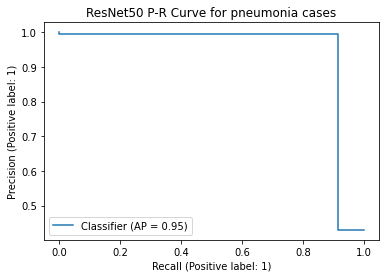

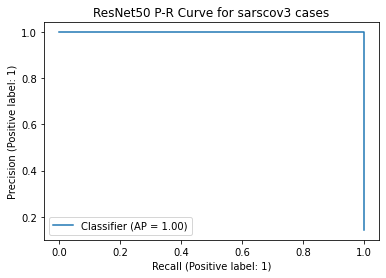

In [ ]:
# Plots the PR curves of your fine-tuned InceptionV3 and ResNet50 models 

# YOUR CODE HERE

norm_pred = []
pneum_pred = []
sars_pred = []
norm_ac = []
pneum_ac = []
sars_ac = []

norm_pred2 = []
pneum_pred2 = []
sars_pred2 = []
norm_ac2 = []
pneum_ac2 = []
sars_ac2 = []

for i in range(len(predicted)):
  if predicted[i] == 0:
    norm_pred.append(1)
  else:
    norm_pred.append(0)
  if predicted[i] == 1:
    pneum_pred.append(1)
  else:
    pneum_pred.append(0)
  if predicted[i] == 2:
    sars_pred.append(1)
  else:
    sars_pred.append(0)

  if actual[i] == 0:
    norm_ac.append(1)
  else:
    norm_ac.append(0)
  if actual[i] == 1:
    pneum_ac.append(1)
  else:
    pneum_ac.append(0)
  if actual[i] == 2:
    sars_ac.append(1)
  else:
    sars_ac.append(0)


for i in range(len(predicted2)):
  if predicted2[i] == 0:
    norm_pred2.append(1)
  else:
    norm_pred2.append(0)
  if predicted2[i] == 1:
    pneum_pred2.append(1)
  else:
    pneum_pred2.append(0)
  if predicted2[i] == 2:
    sars_pred2.append(1)
  else:
    sars_pred2.append(0)

  if actual2[i] == 0:
    norm_ac2.append(1)
  else:
    norm_ac2.append(0)
  if actual2[i] == 1:
    pneum_ac2.append(1)
  else:
    pneum_ac2.append(0)
  if actual2[i] == 2:
    sars_ac2.append(1)
  else:
    sars_ac2.append(0)

iM_norm_disp = PrecisionRecallDisplay.from_predictions(norm_pred, norm_ac)
_ = iM_norm_disp.ax_.set_title('InceptionV3 P-R Curve for normal cases')
iM_pneum_disp = PrecisionRecallDisplay.from_predictions(pneum_pred, pneum_ac)
_ = iM_pneum_disp.ax_.set_title('InceptionV3 P-R Curve for pneumonia cases')
iM_sars_disp = PrecisionRecallDisplay.from_predictions(sars_pred, sars_ac)
_ = iM_sars_disp.ax_.set_title('InceptionV3 P-R Curve for sarscov3 cases')

rM_norm_disp = PrecisionRecallDisplay.from_predictions(norm_pred2, norm_ac2)
_ = rM_norm_disp.ax_.set_title('ResNet50 P-R Curve for normal cases')
rM_pneum_disp = PrecisionRecallDisplay.from_predictions(pneum_pred2, pneum_ac2)
_ = rM_pneum_disp.ax_.set_title('ResNet50 P-R Curve for pneumonia cases')
rM_sars_disp = PrecisionRecallDisplay.from_predictions(sars_pred2, sars_ac2)
_ = rM_sars_disp.ax_.set_title('ResNet50 P-R Curve for sarscov3 cases')

❓ ***Question: Based off the results you obtained in this section, which model performs best? Why do you think (in 5 sentences or less)?***

📝 YOUR ANSWER GOES HERE

The ResNet50 model performs the best for the purpose of being able to predict the patients with sarscov3. From the confusion matrix, it can be seen that there are no false positives or false negatives for sarscov3 detection. The P-R curve for sarscov3 also indicates ResNet50 performing better with an average precision of 1.00 versus 0.99 for InceptionV3.

## Part 6: Answering questions from investors ❓

Bfizer has heard about your model and are interested in investing in your technology. However, before they engage in further discussions, they want you to answer the following questions:

1. Briefly provide techniques that you would explore next to further improve the performance of your model?

2. A competitor has trained an SVM on the same dataset but performs worse than your model. Why do CNNs perform better than SVM for image classification? Discuss two aspects: differences in features and differences in training data.

3. The investors consider investing in a very small device that can run your model. Would your best model fit on this small cost-effective device with 32 MB of storage, assuming that all parameters in the model are 16 bit floats (you can ignore everything in the model but the trainable parameters)? You can use the `torchstat` library ([link](https://github.com/Swall0w/torchstat)) to get the number of parameters. Note that the relevant function from this library was already imported for you (below).

4. If your best model predict a positive SARS-CoV-3 case, how likely is it that you are correct? How likely is it that you are wrong?

5. Assuming that the test data is representative of the disease status among the general population of Canada (it is not, why? hint: think of bias.), how many Canadians (Canada pop: 38M) currently have SARS-CoV-4? How much will it cost Canadians to inject all infected people if one dose of Greenraza™️ can be purchased for 13 CAD (Canadian Dollars)? How many people have pneumonia and need to be isolated? (Show your calculations.)

**Note: Your confusion matrices might be useful for the last 2 questions. 😉**

📝 YOUR SHORT ANSWERS GO HERE (add code cells below as needed for calculations, eg. for running the `stat` function from the `torchstat` package)

1. Experimenting with the weight parameter in cross-entropy loss to deal with data imbalance. Experimenting with other transformations in the images. Experimenting with different batch sizes and base learning rates.

2. CNNs perform better than SVMs as they are able to find non-linear correlations whereas SVM's are limited to linear correlations. CNNs are also able to handle larger datasets in comparison to SVMs. 

3. 

4. According to the P-R curve and confusion matrix table, predicting a positive SARS-CoV-3 case using the ResNet50 is 100 % that it is correct, therefore wrong for 0 %. Realistically whether this would work for all cases, it is unsure, more test data should be used to validate this performance result. However, given the calculated results, as it stands the trained ResNet50 model has a 100 % likelyhood of prediciting a positive SARS-CoV-3 case.

5. 
72/505 = 0.1425
38 M * 0.1425 = 5.42 M.
Therefore 5.42 M would have SARS-CoV-4. It would therefore cost Canadians a total of about $70 M CAD. 

  5.42 M doses  * \$13/dose = $70.43 M

In [ ]:
# Determines the number of trainable parameters in your best model
from torchstat import stat

# YOUR CODE HERE

See? It wasn't that hard, was it?! 😉